In [1]:
import matplotlib as mpl
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.ion()

In [2]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster
import sys
import numpy as np
import csv

path_to_mitie_lib = '/opt/anaconda/anaconda3/lib/python3.6/site-packages/mitie'
path_to_ner_model = '/home/somnus/MITIE-master/MITIE-models/english/ner_model.dat'

sys.path.append(path_to_mitie_lib)

from mitie import *

In [4]:
import pandas as pd

In [5]:
from itertools import cycle, islice

In [174]:
# total number of articles to process
N = 1293

# in memory stores for the topics, titles and contents of the news stories
# topics_array = []
titles_array = []
corpus = []

In [175]:
# Correct this for titles a

file_path = ['../data_sets/articles_1/article-',
             '../data_sets/sci_art/article-',
             '../data_sets/DataSet/article-',
            '']

In [176]:
for i in range(0, N):

    # get the contents of the article
    # art = '/home/somnus/data_sets/articles/article-' + str(i) + '.txt'
    x = str(i)
    with open(file_path[1] + x + '.txt', 'r') as myfile:
        d1 = myfile.read()
        d1 = d1.lower()
        corpus.append(d1)

    # get the title of the article
    # titl = '/home/somnus/data_sets/articles/title-' + str(i) + '.txt'
    with open(file_path[1] + x + '.txt', 'r') as myfile:
        ti1 = myfile.read()
        ti1 = ti1.lower()
        titles_array.append(ti1)

    # get the original topic of the article
    # top = '/home/somnus/data_sets/articles/topic-' + str(i) + '.txt'
    '''with open('topic-' + str(i) + '.txt', 'r') as myfile:
        to1 = myfile.read().replace('\n', '')
        to1 = to1.lower()
        topics_array.append(to1)
        '''

In [177]:
# entity subset array
entity_text_array = []

ner = named_entity_extractor(path_to_ner_model)

for i in range(0, N):

    # Load the article contents text file and convert it into a list of words.
    tokens = tokenize(corpus[i])
    # tokens = tokenize(load_entire_file('/home/somnus/data_sets/articles_1/article-' + str(i) + '.txt'))


    # extract all entities known to the ner model mentioned in this article
    entities = ner.extract_entities(tokens)

    # extract the actual entity words and append to the array
    for e in entities:
        range_array = e[0]
        tag = e[1]
        score = e[2]
        score_text = "{:0.3f}".format(score)
        # entity_text = " ".join(tokens[j] for j in range_array)
        entity_text = " ".join(tokens[i].decode() for i in range_array)
        entity_text_array.append(entity_text.lower())
        
# remove duplicate entities detected
entity_text_array = np.unique(entity_text_array)

In [178]:
vect = TfidfVectorizer(sublinear_tf=True,
                       max_df=0.5,
                       analyzer='word',
                       stop_words='english',
                       vocabulary=entity_text_array)

# corpus_tf_idf = vect.fit_transform(corpus)

X = vect.fit_transform(corpus).todense()

In [179]:
pca = PCA(n_components=2)
data2D = pca.fit_transform(X)

In [180]:
# change n_clusters to equal the number of clusters desired
n_clusters = 3
# n_components = n_clusters

# spectral clustering
spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                      eigen_solver='arpack',)
                                      #affinity="nearest_neighbors",
                                      #n_neighbors=10,
                                      #random_state=10,)

spectral.fit(data2D)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=3, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [181]:
# OUTPUT
# article_number, topic, spectral_clustering_cluster_number, article_title
cluster_assignments = np.int()


if hasattr(spectral, 'labels_'):
    cluster_assignments = spectral.labels_.astype(np.int)

data = list()
collec = dict()
#for i in range(n_clusters):
#    collec[i] = 0

for i in range(0, len(cluster_assignments)):
    data.append([int(i), int(cluster_assignments[i]), str(titles_array[i])])

    # print(i, topics_array[i], cluster_assignments[i], titles_array[i])
    # print(data[-1])
for i in cluster_assignments:
    if i in collec.keys():
        collec[i] += 1
    else:
        collec[i] = 1

In [182]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                    '#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),
                                    int(max(cluster_assignments) + 1))))
#colors = mpl.cm.spectral(cluster_labels.astype(float) / n_clusters)

Text(0.5,1,'Spectral Clustering')

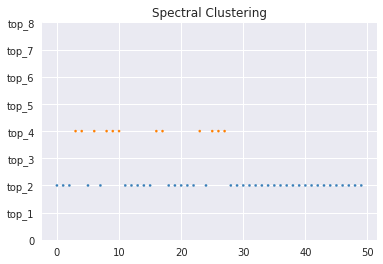

In [183]:
x = [data[i][0] for i in range(0, 50)]
y = [data[j][1] for j in range(0, 50)]
fig, ax = plt.subplots()

ax.scatter(x, y, s=5, color=colors[cluster_assignments])
ax.set_ylim(-1, n_clusters)
ax.set_yticklabels(['0', 'top_1', 'top_2',
                    'top_3', 'top_4',
                    'top_5', 'top_6', 'top_7',
                    'top_8','top_9'])
ax.set_title("Spectral Clustering")

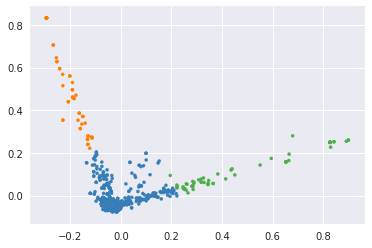

In [184]:
fig1, ax1 = plt.subplots()
ax1.scatter(data2D[:,0], data2D[:,1], alpha=1, s=10, color=colors[cluster_assignments])
# fig1.savefig('/home/somnus/data_sets/clusters/spectral_science_' + str(n_clusters), format='jpg')

In [185]:
collec

{0: 1178, 1: 52, 2: 63}

In [ ]:
data_2D = pd.DataFrame({'x': data2D[:,0], 'y': data2D[:,1]})

In [ ]:
data_2D.plot(x='x', y='y',kind='hexbin',gridsize=35, colormap='cubehelix')

In [ ]:
df = pd.DataFrame(data2D)
#df = df[[0,1]]
#X_clustered = spectral.fit_predict(data2D)
df['X_cluster'] = cluster_assignments

In [ ]:
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

In [14]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

For n_clusters = 2 The average silhouette_score is : 0.820399058351


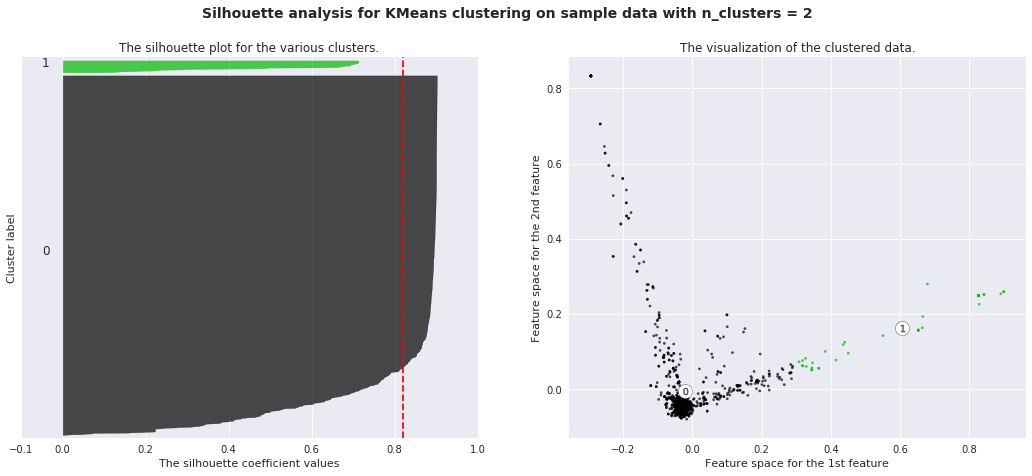

For n_clusters = 3 The average silhouette_score is : 0.836811025526


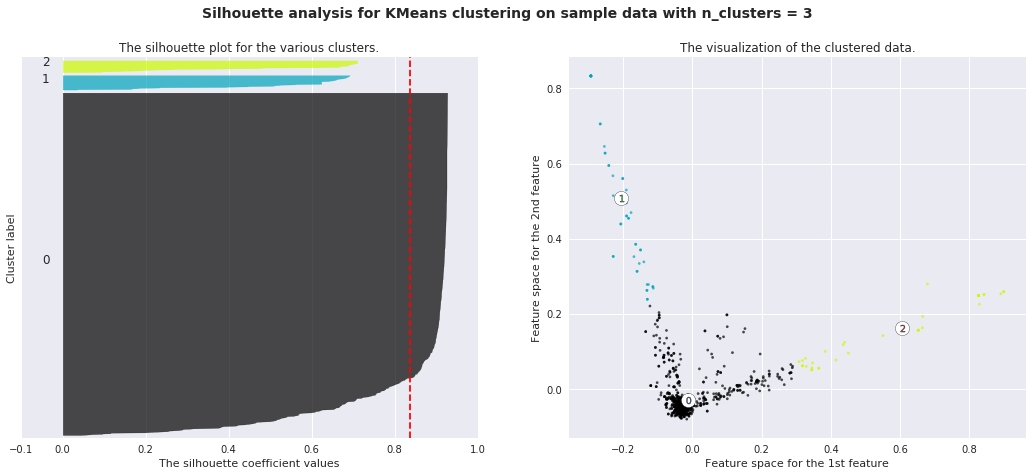

For n_clusters = 4 The average silhouette_score is : 0.768223073173


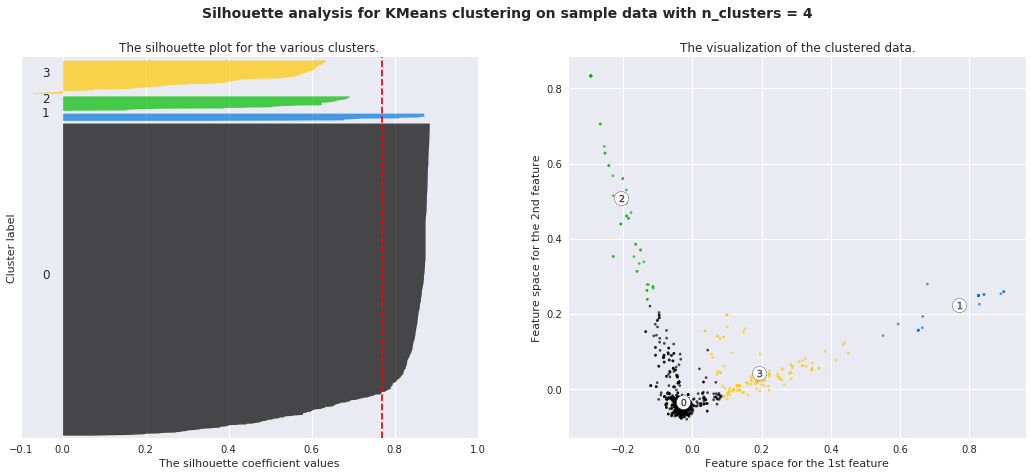

For n_clusters = 5 The average silhouette_score is : 0.773451613341


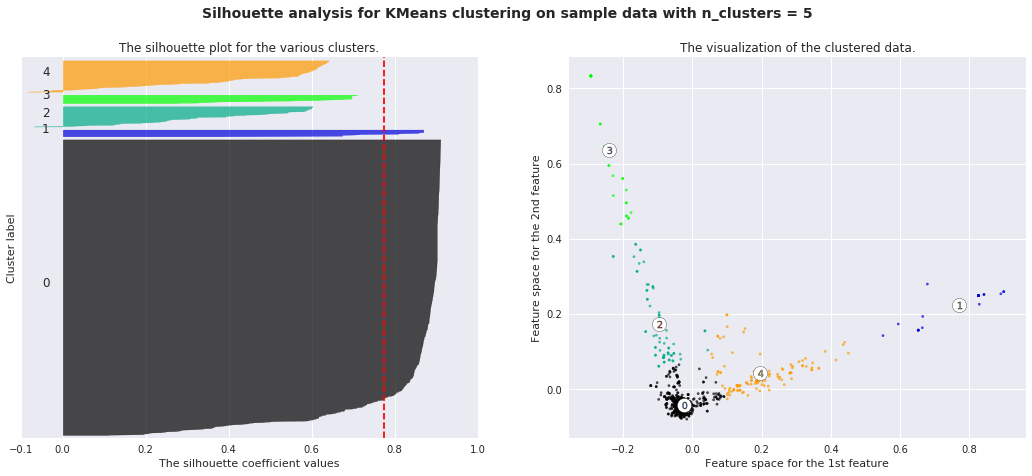

For n_clusters = 6 The average silhouette_score is : 0.737486697674


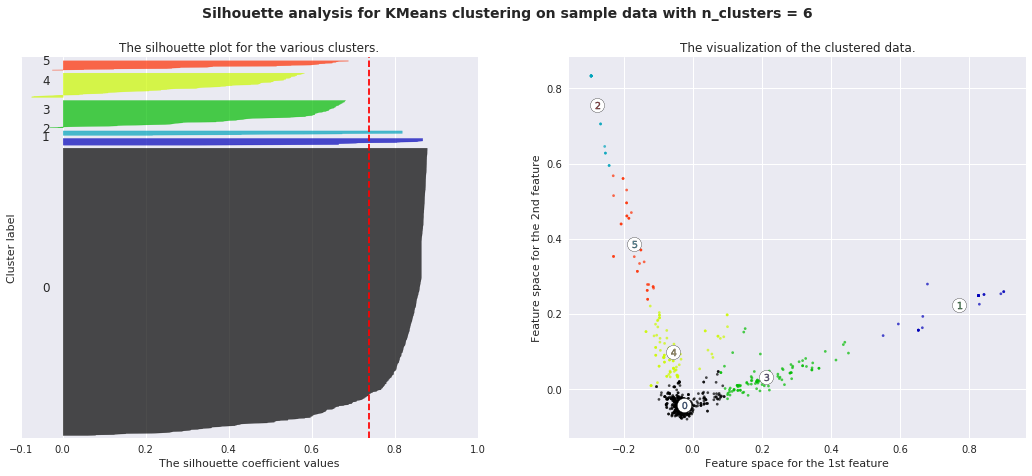

For n_clusters = 10 The average silhouette_score is : 0.685015435847


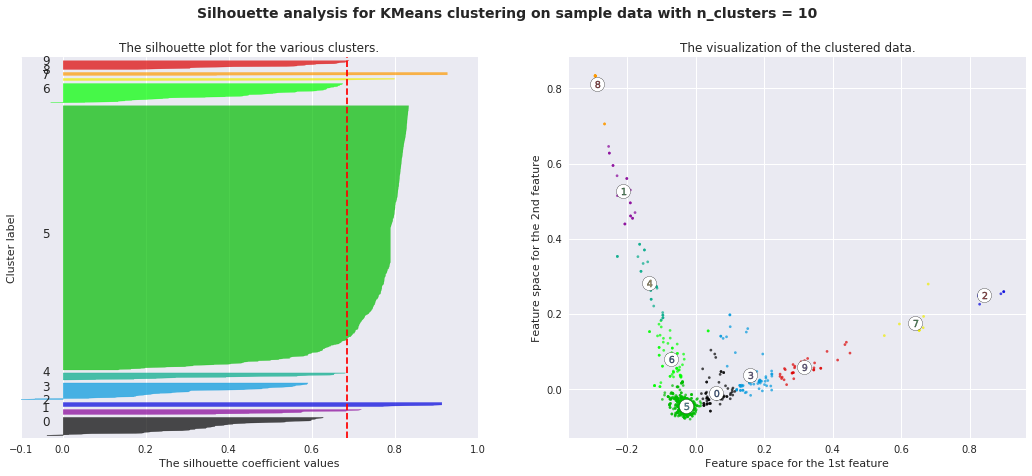

In [189]:
range_n_clusters = [2, 3, 4, 5, 6, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data2D) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    # clusterer = cluster.SpectralClustering(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data2D)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data2D, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data2D, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = mpl.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = mpl.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data2D[:, 0], data2D[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    fig.savefig('../data_sets/clusters/KMeans_sci_'+str(n_clusters)+'.jpg')
    plt.show()

In [136]:
silhouette_score??